In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("/nfs/turbo/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl")
from travel import init_travel
init_travel()

/home/sstorks/.cache/pypoetry/virtualenvs/travel-nQET-zRt-py3.10/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [115]:
import json
import os

# RESULTS_PATH = "/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results_222/vqa_mistake_detection/ego4d_single_debug1000/llava-1.5-7b-hf/IterativeVQA_q10_ego4d_single_debug1000_llava-1.5-7b-hf_beam8-4_likelihood_nohistory_20240821150324"
# RESULTS_PATH = "/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results_222/vqa_mistake_detection/ego4d_single_debug1000/llava-1.5-7b-hf/IterativeVQA_q10_ego4d_single_debug1000_llava-1.5-7b-hf_beam8-4_coherence_nohistory_20240831094306"
# RESULTS_PATH = "/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results_222/vqa_mistake_detection/ego4d_single_debug1000/llava-1.5-7b-hf/IterativeVQA_q10_ego4d_single_debug1000_llava-1.5-7b-hf_beam8-4_coherence_icl20_nohistory_20240821144253"
RESULTS_PATH = "/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results_222/vqa_mistake_detection/ego4d_single_debug1000/llava-1.5-7b-hf/IterativeVQA_q10_ego4d_single_debug1000_llava-1.5-7b-hf_beam8-4_coherence_icl20_nohistory_agla2.0_20240821195807"

with open(os.path.join(RESULTS_PATH, "outputs_test.json"), "r") as f:
    all_results_dicts = json.load(f)
    
with open(os.path.join(RESULTS_PATH, "metrics_coherence_nli_test.json"), "r") as f:
    coherence_metrics = json.load(f)
    
with open(os.path.join(RESULTS_PATH, "metrics_coherence_raw_nli_test.json"), "r") as f:
    coherence_metrics_raw = json.load(f)    

In [116]:
from travel.data.ego4d import Ego4DMistakeDetectionDataset

dataset = Ego4DMistakeDetectionDataset(data_split="test", 
                                       mismatch_augmentation=True,
                                       multi_frame=False,
                                       debug_n_examples_per_class=1000)

# Prepare analysis data

Get positive/negative form of informativeness for better visualization:

In [117]:
import numpy as np
from pprint import pprint

# TODO: once we have access to raw coherence metrics in test results, use 'informativeness_marginal_ref' in them to get positive and negative results - there may be some cases of failure of reasoning in the VLM this could expose
k = 'informativeness_marginal_ref'
unsure_range = 0.1

example_inf = []

parallel_idx = 0
for example_idx, results_dict in enumerate(list(all_results_dicts.values())):
    this_metrics = []
    for question_idx in range(results_dict['final_turn'] + 1):
        # this_inf = round(float(coherence_metrics['metrics_by_turn'][k][example_idx][question_idx]), 6)        
        this_inf = round(float(coherence_metrics_raw[k][parallel_idx]), 6)
        
        this_metrics.append(this_inf)
        
        parallel_idx += 1
            
    # In metric for full example, don't count informativeness for "unsure" answers - model failed to get new information
    this_metrics = [this_metrics[question_idx] if np.abs(results_dict['answer_probs'][question_idx][0] - 0.5) >= unsure_range or "informativeness" not in k else 0.0 for question_idx in range(len(this_metrics))]
    example_metric = round(float(np.max(this_metrics)), 6)
    # if example_metric < 0:
    #     # If all the outputs are negative, use the most negative one instead
    #     example_metric = round(float(np.min(this_metrics)), 6)
    example_inf.append(example_metric)
    
pprint(example_inf[:10])

[0.791992,
 -0.914062,
 0.273438,
 0.608398,
 0.570801,
 0.989258,
 0.697754,
 0.857422,
 0.126953,
 0.852539]


In [118]:
import numpy as np
from pprint import pprint
from tqdm import tqdm

from travel.model.mistake_detection import MISTAKE_DETECTION_THRESHOLDS

accuracy = []
informativeness = []
relevance = []

example_ids = []
verbs = []
nouns = []
mistake_types = []

labels = [] # These have to be filled in later if we want them
graph_name = "base"

assert len(all_results_dicts) == len(example_inf) == len(coherence_metrics['metrics_by_example']['relevance_marginal_by_example'])
for (example_id, output), ex_informativeness, ex_relevance in tqdm(zip(all_results_dicts.items(), example_inf, coherence_metrics['metrics_by_example']['relevance_marginal_by_example']), total=len(all_results_dicts)):
    target_success_prob = 0.0 if output['mistake'] else 1.0
    actual_success_prob = output['success_probs'][output['final_turn']]
        
    accuracy.append(np.abs(target_success_prob - actual_success_prob))
    relevance.append(ex_relevance)
    informativeness.append(ex_informativeness)
    
    example_ids.append(example_id)
    example = dataset.get_example_by_id(example_id, load_frames=False)
    verbs.append(example.verb_noun_pair[0].split("_")[0])
    nouns.append(example.verb_noun_pair[1].split("_")[0])
    mistake_types.append(output['mistake_type'])
    
pprint(list(zip(accuracy, relevance, informativeness, example_ids, verbs, nouns))[:10])

100%|██████████| 2000/2000 [00:02<00:00, 830.36it/s]

[(0.0006880000000000219,
  0.945556,
  0.791992,
  '3fa64efd-45e8-412e-a665-914d0cfda32e/36/pos',
  'put',
  'ketchup'),
 (1.0,
  0.987305,
  -0.914062,
  '1348c9f9-fc8b-40c7-b1ab-5b6281e5d390/296/pos',
  'put',
  'trowel'),
 (0.00020299999999995322,
  0.577392,
  0.273438,
  '3906d25a-d0a4-4a7c-8906-a87cea106c66/183/pos',
  'plant',
  'plant'),
 (0.005730000000000013,
  0.583008,
  0.608398,
  '053ca9bc-4822-4573-b04e-aea0c1ae97df/21/pos',
  'wash',
  'bowl'),
 (0.019418999999999964,
  0.721191,
  0.570801,
  '4894e32d-7aab-4717-981c-9bfc1eac6aa4/16/pos',
  'clean',
  'paintbrush'),
 (4.999999999999449e-05,
  0.436849,
  0.989258,
  '41416e77-3b9a-4685-bd1b-ba26b5ba19b2/102/pos',
  'remove',
  'drill'),
 (0.0006460000000000354,
  0.715699,
  0.697754,
  'afe85823-f95d-4267-91c2-625e2e2e1ea1/87/pos',
  'hold',
  'wall'),
 (0.00016499999999997073,
  0.962402,
  0.857422,
  'f277b970-9a30-467e-9f2f-bc8b36b7c259/5/pos',
  'hold',
  'rod'),
 (0.003403000000000045,
  0.537598,
  0.126953,
 

# Generate graphs

Graph of data dlabels = []
istribution:

In [120]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
matplotlib.use('Agg')

# Sample data
x = accuracy
y = relevance
z = informativeness

# Normalize the values for coloring
# x_norm = (x - np.min(x)) / (np.max(x) - np.min(x))
# y_norm = (y - np.min(y)) / (np.max(y) - np.min(y))
# z_norm = (z - np.min(z)) / (np.max(z) - np.min(z))

x_norm = x
y_norm = y
z_norm = (np.array(z) + 1.0) / 2.0

# Combine the normalized values to get the colors
colors = np.array([x_norm, y_norm, z_norm]).T

fig = plt.figure(figsize=(10, 10))  # Increase the figure size
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot
ax.scatter(x, y, z, c=colors, s=50, edgecolor='k', linewidth=1)

# Data labels
if len(labels) > 0:
    for i in range(len(x)):
        ax.text(x[i], y[i], z[i] + 0.03, labels[i], size=8, zorder=1, color='k')

# Set custom z-axis tick labels
z_ticks = [-1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
ax.set_zticks(z_ticks)
ax.set_zticklabels([f'{tick:.1f}' for tick in z_ticks])
        
# Set axis labels
ax.set_xlabel('Decision Error', labelpad=5, fontsize=16, fontweight='bold')
ax.set_ylabel('Relevance', labelpad=5, fontsize=16, fontweight='bold')
ax.set_zlabel('Informativeness', labelpad=5, fontsize=16, fontweight='bold')

ax.xaxis.label.set_color('#AA0000')
ax.yaxis.label.set_color('#00AA00')
ax.zaxis.label.set_color('#0000AA')

# Set axis limits
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(-1, 1)
ax.set_box_aspect(aspect=None, zoom=0.95)

plt.tight_layout()

# Display the plot
plt.show()
plt.savefig(os.path.join(RESULTS_PATH, f"3d_graph_{graph_name}.pdf"), bbox_inches='tight')


/tmp/ipykernel_2734674/3170518431.py:55: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/tmp/ipykernel_2734674/3170518431.py:58: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


Gather data by verb, noun, and verb-noun pair:

In [53]:
from collections import defaultdict, Counter
import numpy as np
from pprint import pprint

acc_by_verb = defaultdict(list)
acc_by_noun = defaultdict(list)
acc_by_vnpair = defaultdict(list)

rel_by_verb = defaultdict(list)
rel_by_noun = defaultdict(list)
rel_by_vnpair = defaultdict(list)

inf_by_verb = defaultdict(list)
inf_by_noun = defaultdict(list)
inf_by_vnpair = defaultdict(list)

verb_counts = Counter()
noun_counts = Counter()
vnpair_counts = Counter()

for acc, rel, inf, verb, noun in zip(accuracy, relevance, informativeness, verbs, nouns):
    acc_by_verb[verb].append(acc)
    acc_by_noun[noun].append(acc)
    acc_by_vnpair[(verb, noun)].append(acc)
    
    rel_by_verb[verb].append(rel)
    rel_by_noun[noun].append(rel)
    rel_by_vnpair[(verb, noun)].append(rel)
    
    inf_by_verb[verb].append(inf)
    inf_by_noun[noun].append(inf)
    inf_by_vnpair[(verb, noun)].append(inf)
    
    verb_counts[verb] += 1
    noun_counts[noun] += 1
    vnpair_counts[(verb, noun)] += 1            

# Get average metrics for each verb, noun, VN pair
for d in [acc_by_verb, acc_by_noun, acc_by_vnpair, rel_by_verb, rel_by_noun, rel_by_vnpair, inf_by_verb, inf_by_noun, inf_by_vnpair]:
    for k in d:
        d[k] = np.mean(d[k])

pprint(list(acc_by_verb.items())[:10])

[('put', 0.3317103832599119),
 ('plant', 0.00020299999999995322),
 ('wash', 0.233951125),
 ('clean', 0.42970969387755104),
 ('remove', 0.5058662909090909),
 ('hold', 0.3526615395683453),
 ('take', 0.279490144766147),
 ('turn', 0.4124585588235294),
 ('pour', 0.29157972916666663),
 ('paint', 0.45971475)]


Replace scatter plot data lists with gathered verb-noun data:

In [54]:
labels = list([k for k, _ in verb_counts.most_common()])
accuracy = [acc_by_verb[k] for k in labels]
relevance = [rel_by_verb[k] for k in labels]
informativeness = [inf_by_verb[k] for k in labels]

xtitle = "Verb"
graph_name = "verbs"

In [56]:
labels = list([k for k, _ in noun_counts.most_common()])
accuracy = [acc_by_noun[k] for k in labels]
relevance = [rel_by_noun[k] for k in labels]
informativeness = [inf_by_noun[k] for k in labels]

xtitle = "Noun"
graph_name = "nouns"

In [58]:
labels = list([k for k, _ in vnpair_counts.most_common()])
accuracy = [acc_by_vnpair[k] for k in labels]
relevance = [rel_by_vnpair[k] for k in labels]
informativeness = [inf_by_vnpair[k] for k in labels]

labels = [f"{v} {n}" for v, n in labels]

xtitle = "Verb-Noun Pair"
graph_name = "verbs_nouns"

Break down by mistake type:

In [119]:
# target_mistake_type = None
# target_mistake_type = "Action Incomplete"
# target_mistake_type = "MisalignSRL_V"
# target_mistake_type = "MisalignSRL_ARG1"
target_mistake_type = "MisalignSRL_V_ARG1"

accuracy = [acc for acc, mt in zip(accuracy, mistake_types) if mt == target_mistake_type]
relevance = [rel for rel, mt in zip(relevance, mistake_types) if mt == target_mistake_type]
informativeness = [inf for inf, mt in zip(informativeness, mistake_types) if mt == target_mistake_type]
    
print(len(accuracy), "points recovered")
    
xtitle = None # Not implemented for bar graphs
graph_name = f"mistake_type_{target_mistake_type}"


354 points recovered


2D plot:

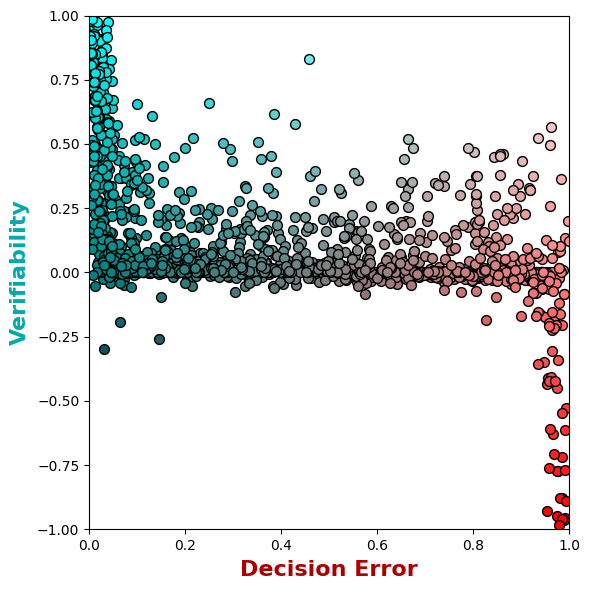

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Sample data
x = accuracy
y = np.array(relevance) * np.array(informativeness)

# Normalize the values for coloring
x_norm = (x - np.min(x)) / (np.max(x) - np.min(x))
y_norm = (y - np.min(y)) / (np.max(y) - np.min(y))

# Combine the normalized values to get the colors
colors = np.array([x_norm, y_norm, y_norm]).T # For more informative/relevant instances, color should shift to more cyan

fig = plt.figure(figsize=(6, 6))  # Increase the figure size
ax = fig.add_subplot(111)

# Create the scatter plot
for i in range(len(x)):
    ax.scatter(x[i], y[i], c=[colors[i]], s=50, edgecolor='k', linewidth=1)

if len(labels) > 0:
    for i in range(len(x)):
        ax.text(x[i], y[i] + 0.01, labels[i], size=8, zorder=1, color='k')

# Set axis labels
ax.set_xlabel('Decision Error', labelpad=5, fontsize=16, fontweight='bold')
ax.set_ylabel('Verifiability', labelpad=5, fontsize=16, fontweight='bold')

ax.xaxis.label.set_color('#AA0000')
ax.yaxis.label.set_color('#00AAAA')

# Set axis limits
ax.set_xlim(0, 1)
ax.set_ylim(-1, 1)

plt.tight_layout()

# Display the plot
plt.show()

Bar graph of verb noun data:

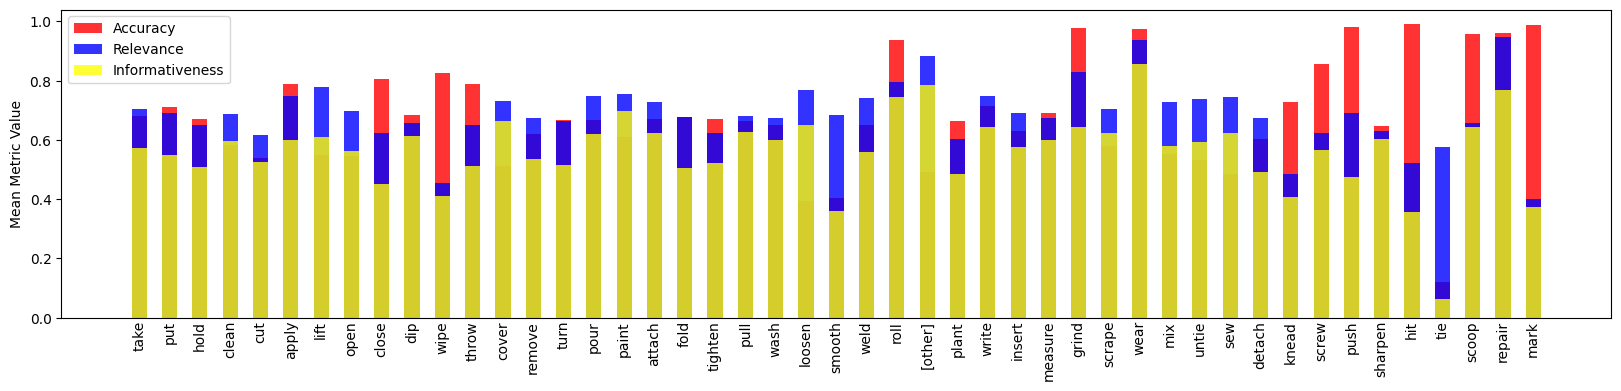

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Example lists
# TODO: we should probably use "multi tiered" versions of these metrics here
A = accuracy[:50]
B = relevance[:50]
C = np.array(informativeness[:50]) * np.array(relevance[:50])

# Number of tuples
n = len(A)

# Define the positions of the bars on the x-axis
indices = np.arange(n)

# Width of a single bar
bar_width = 0.5

# Plot bars
plt.figure(figsize=(20, 4))
plt.bar(indices, A, width=bar_width, color='red', alpha=0.8, label='Accuracy')
plt.bar(indices, B, width=bar_width, color='blue', alpha=0.8, label='Relevance')
plt.bar(indices, C, width=bar_width, color='yellow', alpha=0.8, label='Informativeness')

# Set labels and title
plt.ylabel('Mean Metric Value')

# Remove the x-axis tick labels
plt.xticks([])

# Add a legend
plt.legend()

# Add individual labels under each set of bars
for i, label in enumerate(labels[:50]):
    plt.text(indices[i], -0.01, label, ha='center', va='top', rotation=90)

# Show the plot
plt.show()


# Visualize specific outputs

Next: grab example outputs from different regions

In [95]:
good = []
bad = []
unverified = []
informative_irrelevant = []
relevant_uninformative = []
hallucination = []
knowledge_deficiency = []

for output, err, rel, inf in zip(all_results_dicts.values(), accuracy, relevance, informativeness):
    
    acc = 1 - err
    
    if acc > 0.8 and rel > 0.8 and inf > 0.8:
        good.append(output)
        
    elif acc < 0.2 and rel < 0.2 and inf < 0.2:
        bad.append(output)
    
    elif acc > 0.8 and rel < 0.3 and inf < 0.3:
        unverified.append(output)
        
    elif acc > 0.8 and rel < 0.2 and inf > 0.8:
        informative_irrelevant.append(output)
        
    elif acc > 0.7 and rel > 0.7 and inf < 0.3:
        relevant_uninformative.append(output)
    
    elif acc < 0.3 and rel > 0.7 and inf < 0.0:
        hallucination.append(output)
    
    elif acc < 0.3 and rel > 0.7 and inf > 0.7:
        knowledge_deficiency.append(output)
        
print(len(knowledge_deficiency))

0


In [96]:
import random

# outputs_to_visualize = good
# example_type = "good"

# outputs_to_visualize = bad
# random.shuffle(outputs_to_visualize)
# example_type = "bad"

# outputs_to_visualize = unverified
# example_type = "unverified"

# outputs_to_visualize = informative_irrelevant
# example_type = "informative_irrelevant"

outputs_to_visualize = relevant_uninformative
example_type = "relevant_uninformative"

# outputs_to_visualize = hallucination
# example_type = "hallucination"

# outputs_to_visualize = knowledge_deficiency
# example_type = "knowledge_deficiency"

/nfs/turbo/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_generated_data_0808/ego4d_test_seed222_mismatch_debug1000/3534864b-2289-4aaf-b3ed-10eeeee7acd2/601/easyneg_MisalignSRL_V_0031d268-818c-4ec4-a804-935be610a61a_89.59881/frames


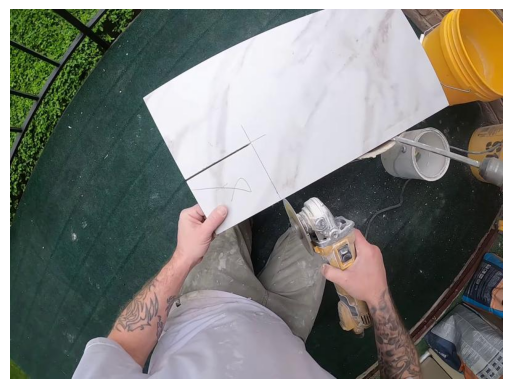

Procedure: Cover the sugar bucket with the bucket cover in your gloved right hand (mistake: MisalignSRL_V)

Q1: Is the person wearing a glove on their right hand?
A1: Unsure ([0.453262, 0.546738])
Success probability 1: 0.04778
/nfs/turbo/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_generated_data_0808/ego4d_test_seed222_mismatch_debug1000/ae2d6792-7bdb-43c4-89b2-fc58c4b977d7/65/easyneg_MisalignSRL_ARG1_94be9e36-7a4b-4b38-8af3-bb395f144b06_166.0380496/frames


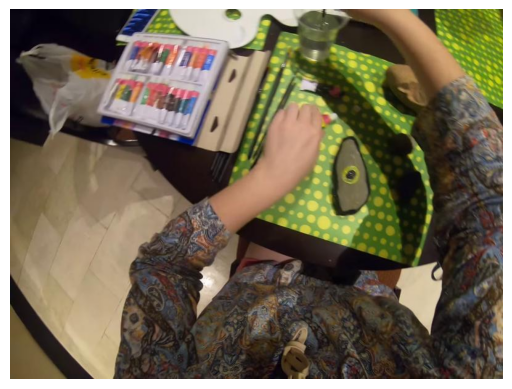

Procedure: Place the blender cup in your hand in a shelf (mistake: MisalignSRL_ARG1)

Q1: Is the person holding the blender cup in their hand?
A1: Yes ([0.314051, 0.68595])
Success probability 1: 0.490236
Q2: Is the blender cup in the person's hand?
A2: Unsure ([0.44553, 0.55447])
Success probability 2: 0.394201
Q3: Is the blender cup placed on a shelf?
A3: No ([0.914901, 0.085099])
Success probability 3: 0.019124
/nfs/turbo/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_generated_data_0808/ego4d_test_seed222_mismatch_debug1000/c957ff4a-780f-4219-a32f-cd8db7fed87b/7/hardneg/frames


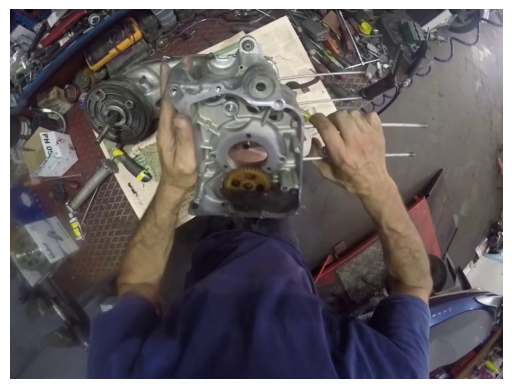

Procedure: Join the part of the carburetor to the carburetor (mistake: Action Incomplete)

Q1: Is the carburetor attached to the engine?
A1: Unsure ([0.542863, 0.457137])
Success probability 1: 0.122523
Q2: Is the carburetor connected to the engine?
A2: Unsure ([0.596433, 0.403567])
Success probability 2: 0.119203
Q3: Is the carburetor connected to the engine in any way?
A3: Unsure ([0.407333, 0.592667])
Success probability 3: 0.114369
/nfs/turbo/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_generated_data_0808/ego4d_test_seed222_mismatch_debug1000/986a0113-6bf3-4426-84a5-c5a78c1ee494/80/easyneg_MisalignSRL_ARG1_6be77236-230f-4d9b-98d5-1cbf3be34023_10.6638396/frames


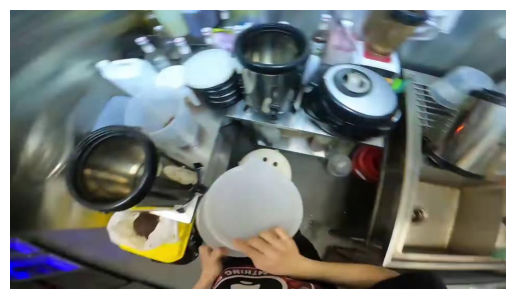

Procedure: Cover the frypan with the pan cover (mistake: MisalignSRL_ARG1)

Q1: Is the frypan on the stovetop?
A1: Yes ([0.341583, 0.658418])
Success probability 1: 0.428233
Q2: Is the frypan covered by the pan cover?
A2: Unsure ([0.5, 0.5])
Success probability 2: 0.203075
Q3: Is the frypan on the stovetop covered by the pan cover?
A3: Unsure ([0.418697, 0.581303])
Success probability 3: 0.169956
Q4: Is the frypan on the stovetop covered with the pan cover?
A4: Unsure ([0.511717, 0.488283])
Success probability 4: 0.16238
/nfs/turbo/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_generated_data_0808/ego4d_test_seed222_mismatch_debug1000/817170ad-1f3b-44b1-9772-fe914fa17f30/1/easyneg_MisalignSRL_V_ARG1_dc306087-4841-4ae3-9136-0dc45716bb9b_59.21359/frames


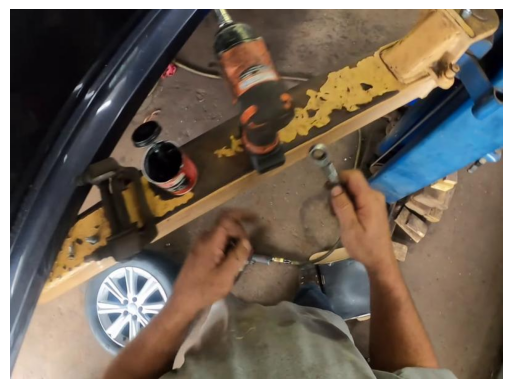

Procedure: Water another plant with the watering sprinkler with your hand (mistake: MisalignSRL_V_ARG1)

Q1: Is the person holding the watering sprinkler in their hand?
A1: Unsure ([0.511717, 0.488283])
Success probability 1: 0.042722
/nfs/turbo/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_generated_data_0808/ego4d_test_seed222_mismatch_debug1000/c8e1a3d0-517b-4553-9621-e14776992fde/170/easyneg_MisalignSRL_ARG1_7bb3ad7f-9bdd-4806-afd6-efb7aa7babbc_39.36189526666667/frames


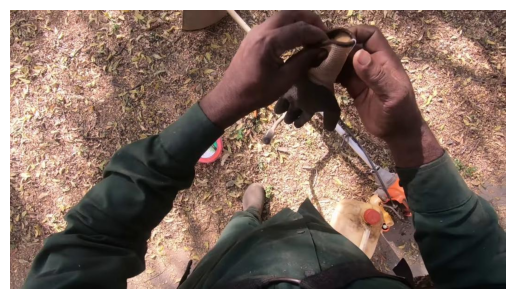

Procedure: Hold another plant stem with your hand (mistake: MisalignSRL_ARG1)

Q1: Is the person's hand visible in the photo?
A1: Yes ([0.096706, 0.903294])
Success probability 1: 0.426322
Q2: Is the person's hand holding the stem of another plant?
A2: Yes ([0.384912, 0.615088])
Success probability 2: 0.890294
Q3: Is the person's hand touching the stem of another plant?
A3: Unsure ([0.464902, 0.535098])
Success probability 3: 0.638835
Q4: Is the person's hand gripping the stem of another plant?
A4: Unsure ([0.407333, 0.592667])
Success probability 4: 0.5
Q5: Is the person's hand grasping the stem of another plant?
A5: Unsure ([0.433981, 0.566019])
Success probability 5: 0.437824
Q6: Is the person's hand holding onto the stem of another plant?
A6: Unsure ([0.426322, 0.573678])
Success probability 6: 0.329392
Q7: Is the person's hand on the stem of another plant?
A7: Unsure ([0.472683, 0.527317])
Success probability 7: 0.314051
Q8: Is the person's hand in contact with the stem of another

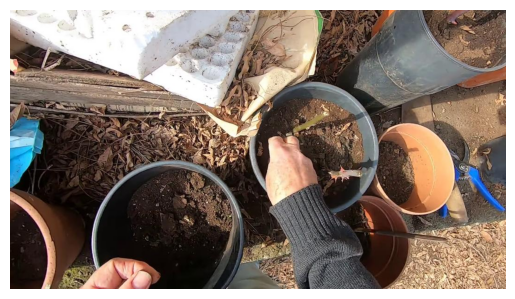

Procedure: Pick a bottle of   mustard from the countertop (mistake: MisalignSRL_ARG1)

Q1: Is the bottle of mustard on the countertop?
A1: Unsure ([0.51562, 0.48438])
Success probability 1: 0.047426
/nfs/turbo/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl_generated_data_0808/ego4d_test_seed222_mismatch_debug1000/cd8282c8-528e-4da8-97d2-2987ca818ff0/9/easyneg_MisalignSRL_V_ARG1_5d672d4f-09fb-477e-8f05-136afa09f2e2_307.19258/frames


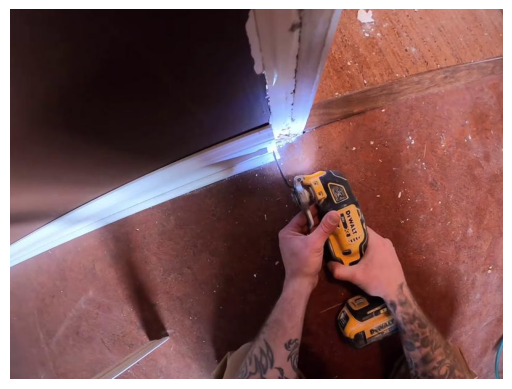

Procedure: Place your left hand on the wood frame (mistake: MisalignSRL_V_ARG1)

Q1: Is the person's left hand on the wood frame?
A1: Unsure ([0.433981, 0.566019])
Success probability 1: 0.108189
Q2: Is the person's right hand on the wood frame?
A2: Unsure ([0.422505, 0.577495])
Success probability 2: 0.074231
Q3: Is the person's hand on the wood frame?
A3: Unsure ([0.403567, 0.596433])
Success probability 3: 0.07477


In [97]:
from PIL import Image
import random
import matplotlib.pyplot as plt
from pprint import pprint

frames = []
for output in outputs_to_visualize:
    
    frame_dir = os.path.join(output['frame_dir'], "frames")
    print(frame_dir)
    possible_frame_dirs = [frame_dir] + [frame_dir.replace("_debug1000","")] + [frame_dir.replace("_debug1000", f"_partition{i+1}of4") for i in range(4)]
    for pfd in possible_frame_dirs:
        try:
            frame_path = os.path.join(pfd, os.listdir(pfd)[0]) # only a single frame in frame dir
            frame = Image.open(frame_path)
            break
        except Exception as e:
            continue
    if frame is not None:
        frames.append(frame)
        plt.figure()
        plt.imshow(frame)
        plt.axis('off')
        plt.show()
    
    print(f"Procedure: {output['procedure']} ({'mistake' if output['mistake'] else 'success'}: {output['mistake_type']})")
    print("")
    for i in range(output['final_turn'] + 1):     
        
        print(f"Q{i+1}: {output['questions'][i]}")
        print(f"A{i+1}: {output['answers'][i]} ({output['answer_probs'][i]})")
        print(f"Success probability {i+1}: {output['success_probs'][i]}")

In [98]:
import json
import os

selected_idx = 2

# Save data for sample outputs
example_dir = os.path.join(RESULTS_PATH, "sample_outputs", example_type)
if not os.path.exists(example_dir):
    os.makedirs(example_dir)

frames[selected_idx].save(os.path.join(example_dir, f"frame_{selected_idx}.png"))
json.dump(outputs_to_visualize[selected_idx], open(os.path.join(example_dir, f"metadata_{selected_idx}.json"), "w"), indent=4)